In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

## Data

In [5]:
train_section = pd.read_table("Article-Bias-Prediction-main/data/randomtraindata.csv", sep=',', index_col=0)
test_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)
val_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)


In [7]:
train_section = train_section[:20000]
val_section = train_section[:4000]



# test_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)
# val_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)


<AxesSubplot:>

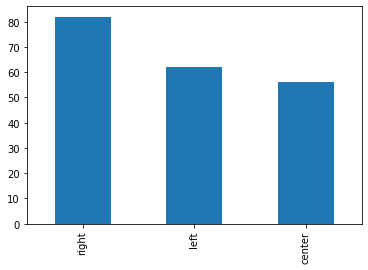

In [8]:
fig, ax = plt.subplots()
train_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

<AxesSubplot:>

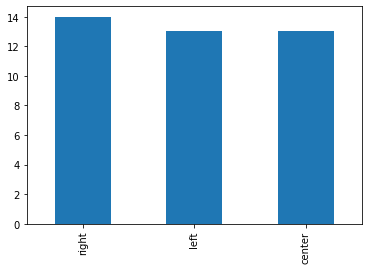

In [9]:
fig, ax = plt.subplots()
val_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

<AxesSubplot:>

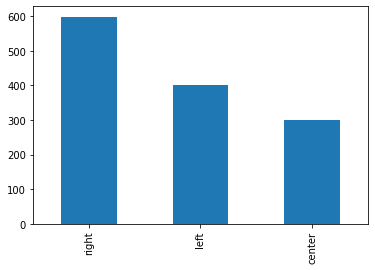

In [10]:
fig, ax = plt.subplots()
test_section["bias_text"].value_counts().plot(ax=ax, kind="bar")

## Hyperparameters

In [11]:
MAX_LEN = 512
nepochs = 50
nbatch = 16

In [12]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/XLNetmodel1"
cache_path_train = f"{data_dir}/cache/XLNetmodel1.train"
cache_path_test = f"{data_dir}/cache/XLNetmodel1.test"

## Transforming Data

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['bias_text']))
val_labels = np.asarray(le.transform(val_section['bias_text']))

In [14]:
# le.inverse_transform(val_labels)[:20]

In [15]:
len(np.unique(train_labels))

3

In [16]:
tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')

In [17]:

def create_input_array(df, tokenizer):
    sentences = df.content.values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids
#     return input_ids, attention_masks



In [20]:
# train_inputs = [create_input_array(train_section, tokenizer=tokenizer_transformer)]
# val_inputs = [create_input_array(val_section, tokenizer=tokenizer_transformer)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()
#     return[ids]
#     return [ids, masks, token_types]
    return [ids, masks]

In [22]:
# train_data = convert_inputs_to_tf_dataset(train_inputs)
# val_data = convert_inputs_to_tf_dataset(val_inputs)

Input ids shape:  (200, 512)
Input Masks shape:  (200, 512)
Token type ids shape:  (200, 512)
Input ids shape:  (40, 512)
Input Masks shape:  (40, 512)
Token type ids shape:  (40, 512)


In [29]:
test_section = pd.read_table("Article-Bias-Prediction-main/data/randomtestdata.csv", sep=',', index_col=0)
test_section.shape

(1300, 12)

In [30]:
test_labels = np.asarray(le.transform(test_section['bias_text']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer)]
test_data = convert_inputs_to_tf_dataset(test_inputs)

Input ids shape:  (1300, 512)
Input Masks shape:  (1300, 512)
Token type ids shape:  (1300, 512)


In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_data, test_labels, batch_size=5)
print("test loss, test acc:", results)


In [31]:
testmodel = TFXLNetForSequenceClassification.from_pretrained("data/experiments/XLNetmodel1", num_labels=len(np.unique(train_labels)))


All model checkpoint layers were used when initializing TFXLNetForSequenceClassification.

All the layers of TFXLNetForSequenceClassification were initialized from the model checkpoint at data/experiments/XLNetmodel1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetForSequenceClassification for predictions without further training.


In [32]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

testmodel.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
testmodel.summary()

In [33]:
# predict probabilities for test set
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

ResourceExhaustedError:  OOM when allocating tensor with shape[512,1024,1,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum (defined at /usr/local/lib/python3.8/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py:140) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_60897]

Errors may have originated from an input operation.
Input Source operations connected to node tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_5/Einsum:
 tfxl_net_for_sequence_classification/transformer/layer_._0/rel_attn/einsum_3/Einsum (defined at /usr/local/lib/python3.8/dist-packages/transformers/models/xlnet/modeling_tf_xlnet.py:301)

Function call stack:
predict_function


In [ ]:
test_probs = test_probs["logits"]

In [ ]:
test_classes = np.argmax(test_probs, axis = 1)

In [ ]:
test_classes

In [ ]:
test_labels

In [ ]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % f1)
 

In [ ]:
train_section.to_csv("train_dataset.csv", sep='\t')
val_section.to_csv("val_dataset.csv", sep='\t')
test_section.to_csv("test_dataset.csv", sep='\t')

In [28]:
# model.save_pretrained(save_path)

In [34]:
tf.keras.backend.clear_session()